<center>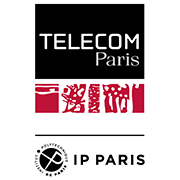</center>

<h1><center><strong><font color="green">IA 717: CHAI & fairness: linguistics of AI ethics charters & manifestos<br/>PART4 : AMR</font></strong></center></h1>

<h3><center><font color="blue"><strong>Student Version</strong></font></center></h3>

<center>
<h3> Project Supervisor</h3>
<a>Maria Boritchev</a> <email>maria.boritchev@telecom-paris.fr</email>

<h3> Project student</h3>
<a>Josephine Bernard</a> <email>josephine.bernard@telecom-paris.fr</email><br/>
<a>Laury Magne</a> <email>laury.magne@telecom-paris.fr</email><br/>
<a>Dan Hayoun</a> <email>dan.hayoun@telecom-paris.fr</email><br/>
<a>Nicolas Allègre</a> <email>nicolas.allegre@telecom-paris.fr</email><br/>


<br/>
Year 2024-2025
</center>

------------------------

### Table of Contents

* [Chapter 0 initialisation Python](#0---code-python-initial)
* [Chapter 4 - AMR](#4---amr)
    * [Section 4.0 - intro et explication](#40-intro-et-explication)
    * [Section 4.1 - initialisation d'utilisation](#41-initialisation-utilisation)
    * [Section 4.2 - analyse AMR](#42-analyse-fearness-à-partir-amr)
        * [Part 4.2.2 - analyse des parents AMR ( **P** )](#422-recherche-des-parents-amr--p-)
        * [Part 4.2.3 - analyse des liens parents AMR ( **F_tag** )](#423-analyse-des-liens-parents-amr--f_tag-)
        * [Part 4.2.4 - analyse des voisins AMR ( **V** )](#424-recherche-des-voisins-amr--v-)

<!-- <a class="anchor" id="0---code-python-initial"></a> -->

# <font color="green">**0 - Code Python initial**</font>

### 0.1) Première partie imports et fonctions globales

In [2]:
# python -m pip install matplotlib numpy scipy sklearn tabulate penman wordcloud

# Global import
import importlib
import itertools
import math
import os
import re
import shutil
import sys
import string
import typing
from collections import Counter
from collections.abc import Iterable
from itertools import islice
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import penman
from scipy.stats import norm  # type: ignore[import-untyped]
from sklearn.feature_extraction.text import CountVectorizer
from tabulate import tabulate
from wordcloud import WordCloud

import metamorphosed.amrdoc as amrdoc
import metamorphosed.amreditor as amreditor
# from Corpus import Corpus

PATH_DATA_FOLDER = '../data'
PATH_LOG_FOLDER = '../log'
PATH_DATA_TXT = '../data/txts'
PATH_DATA_DOCS = '../data/docs'
PATH_DATA_PREPROCESSED = '../data/preprocessed'
PATH_DATA_CORTEX = '../data/corpus_cortext'
PATH_DATA_IRAMUTEQ = '../data/corpus_iramuteq'
PATH_DATA_AMR = '../data/AMR'
FILENAME_DATA_IRAMUTEQ = 'corpus.txt'
FILENAME_DATA_LANG = 'corpus_lang.csv'
FILENAME_DATA_LANG_PREPRO = 'corpus_lang_preprocessing.csv'
FILENAME_DATA_AMR = 'key_penmans.amr'
PATH_DATA_FILE_LANG = os.path.join(PATH_DATA_FOLDER, FILENAME_DATA_LANG)
PATH_DATA_FILE_LANG_PREPRO = os.path.join(PATH_DATA_FOLDER, FILENAME_DATA_LANG_PREPRO)
PATH_DATA_FILE_IRAMUTEQ = os.path.join(PATH_DATA_IRAMUTEQ, FILENAME_DATA_IRAMUTEQ)
PATH_DATA_FILE_AMR = os.path.join('..', FILENAME_DATA_AMR)
TYPE_METHOD = ['cortex', 'iramuteq', 'txt']
CHARSET = 'UTF-8'

sys.path.append('..')


def take(n: int, iterable: Iterable) -> list[any]:
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))
#end def take


def dict_revert(x: dict[str, any], sort: bool=False) -> list[list[str, any]]:
    tmp = x
    if sorted is True:
        tmp = dict(sorted(x.items(), key=lambda item: item[1], reverse=True))
    
    return [[list(x.keys())[i], list(x.values())[i]] for i in range(len(x))]


# Chargement de tout les corpus
# list_corpus = {method: Corpus(method) for method in TYPE_METHOD}

### 0.2) Deuxième partie chargement des données

In [3]:
amr_mapaie = amrdoc.AMRdoc(PATH_DATA_FILE_AMR)

1201 sentences read from ..\key_penmans.amr


# <font color="green">**4 - AMR**</font>

## **4.0) Intro et explication**

### 4.0.1) Mémo d'utilisation

##### **Variable Notebook `amr_mapaie` :**

- **`amr_mapaie`** : variable contenant le chargement du fichier AMR (classe amrdoc.AMRdoc)
  - `amr_mapaie.sentences` : liste contenant toutes les phrases en AMR (classe amrdoc.AMRsentence)
  - `amr_mapaie.sentences.tsv()` : liste de l'AMR au format Graph Penman (triplet)
    - ATTENTION : le format Graph n'est pas unique à partir d'un AMR !!!
    > *Conversion from a PENMAN string to a Tree, and vice versa, is straightforward and lossless. Conversion to a Graph, however, is potentially lossy as the same graph can be represented by different trees.*
  - `amrdoc.relations_between_concepts([amr_mapaie])` : Permet d'avoir un comptage et des stats sommaires.
    - Avec *, depth=1* comme argument, seulement les concepts
    - Avec *, depth=2* (défaut) comme argument, les stats concepts et relation associés


##### **La classe `amrdoc.AMRsentence` :**

 - `amr_mapaie.sentences[0].amr` : l'AMR de la phrase (non parsé)
 - `amr_mapaie.sentences[0].text` : la phrase de l'AMR
 - `amr_mapaie.sentences[0].comments[0]` : le numéro du fichier (Format : 'File xxx')
 - `amr_mapaie.sentences[0].tsv()` : Graph de l'AMR (même remarque)
   - égale à *penman.decode(amr_mapaie.sentences[0].amr)*
 - `amr_mapaie.sentences[0].getconceptlist()` : Retourne la liste des concept de la phrase


##### **Le module `Penman` :**

À utiliser pour plus de précision sur le parcours des graphes/arbres de la syntaxe AMR.

- https://penman.readthedocs.io/en/latest/api/penman.html
- https://penman.readthedocs.io/en/latest/api/penman.graph.html


```python
amr = amr_mapaie.sentences[0].amr
g = penman.decode(amr)
top = g.top  # Sommet de l'arbre
concepts = {}
# for s, p, o in amr_mapaie.sentences[0].tsv():
for s, p, o in g.instances():
  # s = source – the source variable of the triple (g.top est le sommet)
  # p = role – the edge label between the source and target
  # o = target – the target variable or constant => C'est le concept pour les noeuds
  if p == ":instance":
    concepts[s] = o
...
```


### 4.0.2) Aide analyse AMR

Le fichier AMR de mapaie, `key_penmans.amr` est un fichier brut pouvant être lu en texte.
- La ligne *::snt* est la phrase originelle
- Suivie du numéro de fichier*
- Suivie de la syntaxe AMR (Penman)

Normalement, il n'y a pas besoin de lire directement ce fichier, juste à utiliser la variable `amr_mapaie`.

Aide sur la syntaxe AMR : https://github.com/amrisi/amr-guidelines/blob/master/amr.md


### 4.0.3) Exemple d'utilisation dans amrdoc :

In [ ]:
def relations_between_concepts(ads, depth=2):
    output = []
    concepts = {} # {concept: {relation: {concept: freq}}}
    for ad in ads:
        for sent in ad.sentences:
            instances = {} # inst: concept
            for s, p, o in sent.tsv():
                if p == ":instance":
                    instances[s] = o
            for s, p, o in sent.tsv():
                if p != ":instance":
                    sclass = instances[s]
                    oclass = instances.get(o, "lit:" + o)

                    if depth == 1:
                        if sclass in concepts:
                            concepts[sclass] += 1
                        else:
                            concepts[sclass] = 1
                        continue

                    if sclass in concepts:
                        relations = concepts[sclass]
                    else:
                        relations = {}
                        concepts[sclass] = relations

                    if depth == 2:
                        if p in relations:
                            relations[p] += 1
                        else:
                            relations[p] = 1
                        continue

                    if p in relations:
                        objectconcepts = relations[p]
                    else:
                        objectconcepts = {}
                        relations[p] = objectconcepts
                    if oclass in objectconcepts:
                        objectconcepts[oclass] += 1
                    else:
                        objectconcepts[oclass] = 1
    for c in sorted(concepts):
        if depth == 1:
            #print(c, concepts[c], sep="\t")
            output.append("%s\t%s" % (c, concepts[c]))
            continue
        #print(c)
        output.append(c)
        for r in sorted(concepts[c]):
            if depth == 2:
                #print("   %s\t%s" % (r, concepts[c][r]))
                output.append("   %s\t%s" % (r, concepts[c][r]))
                continue
            #print("   ", r)
            output.append("   " + r)
            for oc in sorted(concepts[c][r]):
                #print("     %s\t%s" % (oc, concepts[c][r][oc]))
                output.append("     %s\t%s" % (oc, concepts[c][r][oc]))

    return output


## **4.1) Initialisation utilisation**

In [21]:
c1 = [x.split('\t') for x in amrdoc.relations_between_concepts([amr_mapaie], depth=1)]
c2 = [x.split('\t') for x in amrdoc.relations_between_concepts([amr_mapaie], depth=2)]

# Concepts présents dans les AMR de mapaie
concepts = set(x[0] for x in c1)
# Type de relation présents dans les AMR de mapaie
relations = set(x[0] for x in c2) - concepts

Il faut chercher dans cette liste ceux qui se rapporte à **fairness** pour pourvoir effectuer les analyses à faire.

- Une première méthode simple est de regarder cette liste `concepts` dans la lettre 'f' :
  >'face-01', 'facet', 'facilitate-01', 'facility', 'fact', 'factor', 'factor-01', 'fail-01', 'fair-01', 'fairness', 'fairwash-01', 'fall-01', 'fall-04', 'fallacy', 'familiarize-01', 'fatality', 'feasibility', 'feature', 'feature-01', 'federate-01', 'feed-01', 'feed-02', 'feedback', 'feel-01', 'few', 'fidelity', 'field', 'fight-01', 'figure', 'fill-01', 'fill-in-05', 'find-01', 'find-02', 'fine-04', 'fire-02', 'firm', 'fit-01', 'fit-03', 'fit-06', 'fix-03', 'flaw-01', 'flexibility', 'flow-01', 'focus-01', 'follow-01', 'follow-02', 'follow-04', 'follow-through-07', 'foresee-01', 'foreword', 'forgive-01', 'form', 'form-01', 'formalize-01', 'formula', 'formulate-01', 'foster-01', 'found-01', 'foundation', 'frame', 'frame-06', 'framework', 'free-04', 'frequent-02', 'friendly-01', 'from', 'fulfill-01', 'full-09', 'fun-01', 'function', 'function-01', 'functional-03', 'fund', 'fund-01', 'furnish-01', 'fuse-01', 'future'
  - **'fair-01', 'fairness', 'fairwash-01'** pourrait nous interresser.
  - *À noter que 'fairness' n'existe pas dans les concepts de probBank*

- Une deuxième méthode serait pour chaque phrase qui ne contient pas les concepts AMR 'fair-01', 'fairness', regarder manuellement comment le mot fairness a été transcrit.


Ensuite, on pourrait se renseigner au sens des mots choisis dans les fichiers XML de probBank [lien](https://github.com/propbank/propbank-frames/tree/main/frames) (ou sur l'application metamorphosed).

In [22]:
stat_concept = dict.fromkeys(sorted(concepts), 0)
for x in c1:
    stat_concept[x[0]] = int(x[1])

stat_relation = dict.fromkeys(sorted(relations), 0)
stat_concept_relation = dict.fromkeys(sorted(concepts), {})
tmp_concept = list(stat_concept_relation.keys())[0]
for x in c2:
    if len(x) == 1 and x[0] in concepts:  # C'est un concept
        tmp_concept = x[0]
        stat_concept_relation[tmp_concept] = dict.fromkeys(sorted(relations), 0)
        continue
    
    if len(x) > 1:  # C'est une relation associé au concept précédant
        stat_relation[x[0]] += int(x[1])
        stat_concept_relation[tmp_concept][x[0]] = int(x[1])


# stat_concept : contient les stats d'utilisation des concepts
# stat_relation : contient les stats d'utilisation du type de relation
# stat_concept_relation : contient les stats d'utilisation des type de relation par concept

In [23]:
tmp = dict(sorted(stat_concept.items(), key=lambda item: item[1], reverse=True))
pprint({k: tmp[k] for i, k in enumerate(tmp) if i < 20}, sort_dicts=False)

# tmp = dict(sorted(stat_relation.items(), key=lambda item: item[1], reverse=True))
# pprint({k: tmp[k] for i, k in enumerate(tmp) if i < 20}, sort_dicts=False)

{'and': 5658,
 'name': 2995,
 'multi-sentence': 1020,
 'or': 572,
 'possible-01': 569,
 'publication-91': 395,
 'person': 379,
 'publication': 362,
 'intelligent-01': 354,
 'use-01': 354,
 'have-degree-91': 334,
 'mean-01': 305,
 'date-entity': 300,
 'principle': 278,
 'recommend-01': 257,
 'fair-01': 256,
 'develop-02': 249,
 'system': 246,
 'cause-01': 234,
 'ensure-01': 233}


In [24]:
# Première initialisation des concepts AMR liés à FAIRNESS :
list_concept_tosee = ['fair-01', 'fairness', 'fairwash-01']

# Filtre pour l'affichage
list_relation_tosee = set([y for x in list_concept_tosee for y in stat_concept_relation[x] if stat_concept_relation[x][y] != 0])
# tmp = {x: {y.strip(): stat_concept_relation[x][y] for y in list_relation_tosee} for x in list_concept_tosee}
# print(tabulate(tmp.values(), showindex=list_concept_tosee, headers='keys', tablefmt='pipe'))

tmpbis = {y.strip(): {x: stat_concept_relation[x][y] for x in list_concept_tosee} for y in list_relation_tosee}
print(tabulate(tmpbis.values(), showindex=list_relation_tosee, headers='keys', tablefmt='pipe'))


|              |   fair-01 |   fairness |   fairwash-01 |
|:-------------|----------:|-----------:|--------------:|
| :mod         |        13 |        105 |             0 |
| :polarity    |        58 |         42 |             0 |
| :topic       |         0 |         10 |             0 |
| :li          |         0 |          2 |             0 |
| :ARG0        |         5 |          0 |             1 |
| :ARG1        |       156 |          0 |             1 |
| :degree      |         1 |          0 |             0 |
| :source      |         0 |          1 |             0 |
| :prep-on     |         0 |          1 |             0 |
| :beneficiary |         0 |          2 |             0 |
| :domain      |         1 |          5 |             0 |
| :ARG3        |         1 |          1 |             0 |
| :quant       |         0 |          1 |             0 |
| :manner      |         5 |          6 |             1 |
| :location    |         3 |          5 |             0 |
| :poss       

## **4.2) Analyse *Fearness* à partir AMR**

Nous nous interressons au voisinage de l'utilisation du mot fairness dans le graph AMR :

<pre style='font=font-family:Courier New, Courier, monospace;'>
        =====
        = P =
        =====
         / \
  V_tag /   \ F_tag
       /     \
   =====     =====
   = V =     = F =
   =====     =====
               |
               | E_tag
               |
             -------
             |  E  |
             | ... |
             -------
</pre>
**Explications :**
- F : Le noeud où le concept de *fairness* apparait
- P : le concept parent
- V : le concept voisin, lié à *fairness* par le parent
- E : les concepts enfants
- x_tag : les tags AMR associés

#### Recherche à faire :
<font color="red">Faire les statistiques puis analyser avec les précédents constats de notre analyse PosTag :
- P( P )
- P( F_tag )
- P( V )
- P( V \ P)
- P( V_tag, F_tag )
- P( E_tag )
- P( {E}=∅ ) : Fairness n'a pas d'enfant
- P( rang(E)=1 ) : Fairness n'a qu'un enfant
- P( rang(E)>1 ) : Fairness à plusieurs enfants

</font>

In [ ]:
# TEST TO SAVE IMAGE des graph AMR (pour les profs) :

# dataformat = 'png'
# self.aps = {} # parsed and possibly modified PENMAN AMRs
#  # initial version of Penman graph
# for sentnum, cursentence in enumerate(self.amrdoc.sentences, start=1):
#     if sentnum % 10 == 0:
#         print("%d initialized" % sentnum, end="\r")
#     ap = amreditor.AMRProcessor()
#     self.aps[sentnum] = ap
#     ap.lastpm = cursentence.amr
#     ap.comments = cursentence.comments

# dataformat = 'png'
# for ix, x in enumerate(self.aps, 1):
#     ap = self.aps[x]
#     if not ap.isparsed:
#         ap.readpenman(ap.lastpm)
#     pm, svg, svg_canon = ap.show(format=dataformat)
#     if svg:
#         print("%d.%s" % (ix, dataformat), svg)

# # show()
# try:
#     pm = penman.encode(penman.Graph(self.triples, top=self.top))
#     self.readpenman(pm)
#     self.lastsvg = self.dot(highlightinstances, highlightrelations, format=dataformat)
#     self.lastsvg_canonised = self.dot(highlightinstances, highlightrelations, format=dataformat, inverse_of=True)
#     self.isDisconnected = False
# except penman.exceptions.LayoutError:
#     print("not yet correct")
#     print(self.triples)



### 4.2.0) Exemple d'utilisation de la syntaxe penman AMR

In [28]:
sentnum = 1
cursentence = amr_mapaie.sentences[0]
# for sentnum, cursentence in enumerate(amr_mapaie.sentences, start=1):
#     pass

# Initialisation du parsing :
ap = amreditor.AMRProcessor()
ap.lastpm = cursentence.amr
ap.comments = cursentence.comments
if not ap.isparsed:
    ap.readpenman(ap.lastpm)

# Utilisation : 1- liste des concepts
ap.vars

{'p': 'possible-01',
 'f': 'facilitate-01',
 'o': 'or',
 'r': 'regulate-01',
 'e': 'exist-01',
 'r2': 'regulate-01',
 'n': 'new-01',
 'o2': 'or',
 'a': 'accountable-02',
 'a2': 'algorithm',
 'f2': 'fair-01',
 'a3': 'amr-unknown',
 'f3': 'first-of-all'}

In [33]:
# Utilisation : 2- arbre AMR entier sous une liste de triplet
ap.triples

# 1- Vérifier values ap.vars == fairness et récupérer la clé (id)
# 2- Récupérer triplet F_tag (ap.triples[2]==id) (id_P, type_F_tag, id)
# 3- Sortir le parent P (ap.vars[id_P] => concept)
# 4- Sortir triplet V_tag (ap.triples[0]==id_P and ap.triples[1]!=':instance') (id_p, type_V_tag,id_V)
# 5- Sortir le voisin V (ap.vars[id_V] => concept)
    # enfants_F = [x for x in ap.triples if x[0]==id and x[2]!=fearness]
    # ids_E=[x[2] for x in enfants_F]
# 6- Nombre branche fairness : len(enfants_F)
# 7- concept enfant : [ap.vars[x] for x in ids_E]
# 8- Nb petit-enfant : len(ap.triples if x[0]==ids_E and != ap.vars[ids_E]|concept)


[('p', ':instance', 'possible-01'),
 ('p', ':ARG1', 'f'),
 ('p', ':mod', 'f3'),
 ('f', ':instance', 'facilitate-01'),
 ('f', ':ARG0', 'o'),
 ('f', ':ARG1', 'o2'),
 ('f', ':manner', 'a3'),
 ('o', ':instance', 'or'),
 ('o', ':op1', 'r'),
 ('o', ':op2', 'r2'),
 ('r', ':instance', 'regulate-01'),
 ('r', ':ARG1-of', 'e'),
 ('e', ':instance', 'exist-01'),
 ('r2', ':instance', 'regulate-01'),
 ('r2', ':ARG1-of', 'n'),
 ('n', ':instance', 'new-01'),
 ('o2', ':instance', 'or'),
 ('o2', ':op1', 'a'),
 ('o2', ':op2', 'f2'),
 ('a', ':instance', 'accountable-02'),
 ('a', ':mod', 'a2'),
 ('a2', ':instance', 'algorithm'),
 ('f2', ':instance', 'fair-01'),
 ('a3', ':instance', 'amr-unknown'),
 ('f3', ':instance', 'first-of-all')]

### 4.2.1) Fonctions permettant d'extraire le voisinage

In [ ]:
# Fonctions récupèrant le parent
def get_parent_infos(targets, amr_sentence):
    """Recherche les parents d'un concept (noeud AMR) pour une phrase

    :param list[str] targets: liste de concept à rechercher
    :param amrdoc.AMRsentence amr_sentence: phrase à analyser
    :return results, racines:
        results[concept_target] = [parent_id, parent_type, relation, amr_sentence]
        racines: list = list des phrases dont le concept et le sommet de l'arbre
    """
    # Initialisation de l'AMRProcessor
    ap = amreditor.AMRProcessor()
    ap.lastpm = amr_sentence.amr
    ap.comments = amr_sentence.comments
    if not ap.isparsed:
        ap.readpenman(ap.lastpm)
    
    results = {}
    racines = []
    for target in targets:
        target_vars = ap.getvars(target)
        if target_vars:
            infos = []
            for target_var in target_vars:  # Parcourir toutes les occurrences du mot
                has_parent = False
                for triple in ap.triples:
                    if triple[2] == target_var:
                        parent_var = triple[0]
                        relation = triple[1]
                        parent_type = ap.vars[parent_var]
                        infos.append((parent_var, parent_type,
                                     relation, amr_sentence))
                        has_parent = True

                if not has_parent:
                    infos.append(("NA", "NA", "NA", amr_sentence))
                    racines.append((amr_sentence, amr_sentence))
            
            results[target] = infos
    
    return results, racines


def get_all_parents(targetlist, amr_sentences):
    """Recherche les parents d'un concept (noeud AMR) dans tout le corpus

    :param list[str] targetlist: liste de concept à rechercher
    :param list[amrdoc.AMRsentence] amr_sentences: list des phrase du corpus
    :return results, racines:
        results[concept_target] = [parent_id, parent_type, relation, amr_sentence]
        racines: list[list] = list des phrases dont le concept et le sommet de l'arbre
    """
    results = {}
    racines = []
    for i, sentence in enumerate(amr_sentences):
        results[i], racine = get_parent_infos(targetlist, sentence)
        if racine:
            racines.append(racine)

    return results, racines


# Fonctions récupèrant les enfants
def get_node_children(node_id, amr_sentence, list_concept_tosee):
    # Initialisation de l'AMRProcessor
    ap = amreditor.AMRProcessor()
    ap.lastpm = amr_sentence.amr
    ap.comments = amr_sentence.comments
    if not ap.isparsed:
        ap.readpenman(ap.lastpm)

    children = []  # Liste des enfants avec leurs liens

    # Parcourir les triples pour trouver les enfants du noeud donné
    for triple in ap.triples:
        if triple[0] == node_id:  # Si le noeud est le sujet
            child_id = triple[2]  # Identifiant de l'enfant
            relation = triple[1]  # Relation entre le noeud et l'enfant
            # Type de l'enfant (s'il existe)
            child_type = ap.vars.get(child_id, "NA")
            if child_type in list_concept_tosee:
                continue
            children.append((child_id, child_type, relation,
                            amr_sentence.comments[0]))

    return children


def get_all_node_children(parents, list_concept_tosee):
    childrens = []
    for index, list_parents in parents.items():
        for word_fair, list_parents in list_parents.items():
            for parent in list_parents:
                children = get_node_children(
                    parent[0], parent[3], list_concept_tosee)
                childrens.append(children)
    
    return childrens

### 4.2.2) Recherche des parents AMR ( **P** )

In [ ]:
list_concept_tosee = ['fair-01', 'fairness', 'fairwash-01']
parents, racines = get_all_parents(list_concept_tosee, amr_mapaie.sentences)

# comptage des parents
count_words_fair = {}
for fair in list_concept_tosee:
    count_words_fair[fair] = 0

count_parents_type = {}
count_parents_link = {}
for index, list_parents in parents.items():
    for word_fair, list_parents in list_parents.items():
        for parent in list_parents:
            count_words_fair[word_fair] += 1
            if parent[1] in count_parents_type:
                count_parents_type[parent[1]] += 1
            else:
                count_parents_type[parent[1]] = 1
            if parent[2] in count_parents_link:
                count_parents_link[parent[2]] += 1
            else:
                count_parents_link[parent[2]] = 1


#### 4.2.2.1) Analyse des noeuds parents AMR

Maintenant, nous pouvons effecter une représentation en nuage de mot de parent du concept fair* :

type de parent :
and: 476
define-01: 57
principle: 51
or: 44
ensure-01: 32
multi-sentence: 28
realize-01: 24
assess-01: 16
criteria: 15
concept: 14


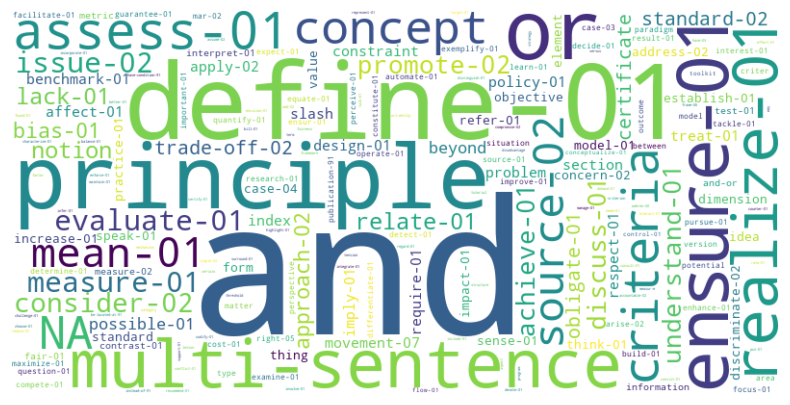

In [ ]:
print("type de parent :")
top_10 = sorted(count_parents_type.items(), key=lambda x: x[1], reverse=True)[:10]

# Afficher le Top 10
for key, value in top_10:
    print(f"{key}: {value}")

# nuage de mots
# Créer le nuage de mots
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="viridis"
).generate_from_frequencies(count_parents_type)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Supprime les axes
plt.show()


**Analyses :**
- Plus d'un tiers des parents sont une jonction de 2 concepts.
- L'analyse AMR confirme notre analyse précédente avec les postags
- Fairness est donc souvent associé à un autre concept.


#### 4.2.2.2) Analyse du cas où il lui-même parent

Il est maintenant interessant d'étudier les phrases dont le concept fair* est racine de l'arbre AMR

In [ ]:
for sentence in racines:
    print(sentence[0][0].comments[0] + " : " + sentence[0][0].text)


File 89 : Fairness.
File 157 : Fairness through awareness.
File 157 : Counterfactual fairness.
File 157 : https://doi.org/10.1007/s12599 -017-0487 -z      Outcome fairness
File 157 : Path -specific counterfactual fairness.
File 157 : Fairness through awareness.
File 157 : Counterfactual fairness.
File 157 : Fairness beyond disparate treatment &  disparate impact: Learning classification without disparate mistreatment.
File 157 : Fairness in decision -making the causal explanation formula.
File 18 : Fairness.
File 18 : Fairness.
File 78 : 'Fairness through  awareness. '
File 128 : They fairwash a model by taking a closed-box model and produce an ensemble of interpretable models that approximate the original model but are much fairer, which then hide the unfairness of the original model.


**Analyse :**

- Seules 13 occurences en tant que racine de l'arbre AMR
- Concerne majoritairement des titres ou des occurences seules
- Donc aucune signification sématique pour nous

#### 4.2.2.3) Analyse particulière pour *fearwash*

**Focus sur le concept *fairwash* :**

Ce concept n'existe pas dans PropBank et a donc été inventé par le NN. Cependant, le réseau de neurones a considéré ce concept particulier et donc de distance dimensionnelle plus éloignée que les concepts de fair/fairness. D'où, l'intérêt pour nous d'effectuer une analyse plus poussée sur ce résultat de la sortie du NN.


In [ ]:
# Total des occurrences
total = sum(count_parents_type.values())

# Proportion de "and"
proportion_and = count_parents_type['and'] / \
    total if 'and' in count_parents_type else 0

# Affichage
print(f"Proportion de 'and': {proportion_and:.2%}")

Proportion de 'and': 36.25%


### 4.2.3) Analyse des liens parents AMR ( **F_tag** )

In [ ]:
print("lien avec le parent :")
top_10_2 = sorted(count_parents_link.items(), key=lambda x: x[1], reverse=True)[:10]

# Afficher le Top 10
for key, value in top_10_2:
    print(f"{key}: {value}")

lien avec le parent :
:ARG1: 407
:op1: 263
:op2: 175
:topic: 113
:op3: 61
:mod: 55
:ARG2: 49
:ARG1-of: 40
:ARG0: 35
:op4: 23


In [ ]:
# Total des occurrences
total = sum(count_parents_link.values())

# Proportion de "ARG1"
proportion_ARG1 = count_parents_link[":ARG1"] / \
    total if ":ARG1" in count_parents_link else 0
# Proportion de ":opX"
proportion_opX = (count_parents_link[":op1"] + count_parents_link[":op2"] + count_parents_link[":op3"]) / \
    total if ":op1" in count_parents_link or ":op2" in count_parents_link or ":op3" in count_parents_link  else 0

print(f"Proportion de ':ARG1': {proportion_ARG1:.2%}")
print(f"Proportion de ':opX': {proportion_opX:.2%}")

Proportion de ':ARG1': 31.00%
Proportion de ':opX': 38.00%


**Analyses :**
- Le lien avec le parent peut aussi porter du sens.  
- opx sont en grande majorité liés à un jonction (and) ou un dijonction (or)
- ARG1 est autant présent que les liens précedement. Il représente que "fair" est l'objet affecté par le parent.

Lorsque l'on recherchera les voisins AMR, il faudrait donc effectuer une apparté vis-à-vis de ce lien.

### 4.2.4) Recherche des voisins AMR ( **V** )

#### 4.2.4.1) Analyse générale des voisins AMR

Ainsi, nous pouvons aller rechercher les concepts associés :

In [ ]:
neighbors = get_all_node_children(results, list_concept_tosee)
# dans neighbors[2]:
# [('and', 'NA', ':instance', 'File 150'), => parent
# ('t', 'transparency', ':op1', 'File 150')] => enfant
# exemple, dans le fichier 150 le mot fairness est joint avec transparency
# Cherchons toutes ces jonctions
neighbor_concepts = []
for neighbor in neighbors:
    if neighbor:
        parent = neighbor[0]  # Le premier élément est le parent
        children = neighbor[1:]  # Les éléments suivants sont les enfants  
        if parent[0] == "and":
            for child in children:
                neighbor_concepts.append(child[1])

# Compter les occurrences
word_counts = Counter(neighbor_concepts)
pprint(word_counts)


Counter({'transparency': 131,
         'accountable-02': 111,
         'safe-01': 50,
         'explain-01': 37,
         'privacy': 36,
         'and': 35,
         'justice': 30,
         'discriminate-02': 29,
         'bias-01': 26,
         'security': 26,
         'possible-01': 21,
         'discriminate-01': 18,
         'govern-01': 17,
         'include-01': 17,
         'right-05': 17,
         'value': 15,
         'publication': 15,
         'private-02': 14,
         'equal-01': 14,
         'ethics': 14,
         'respect-01': 13,
         'accurate': 13,
         'accuracy': 13,
         'learn-01': 12,
         'protect-01': 11,
         'prevent-01': 11,
         'impact-01': 11,
         'robustness': 11,
         'law': 10,
         'limit-01': 10,
         'diversity': 9,
         'NA': 8,
         'deserve-01': 7,
         'sustain-01': 7,
         'et-cetera': 7,
         'assess-01': 7,
         'interpret-01': 7,
         'name': 6,
         'dignity': 6,
     

**Analyses :**

Plus de la moitié des concepts associés portent sur la possibilité de comprendre :
- 'transparency': 131
- 'accountable-02': 111
- 'explain-01': 37  

On peut en déduire que fairness est en effet un but mais qu'on ne peut y parvenir sans comprendre le fonctionnement (explicabilité).

#### 4.2.4.2) Analyse des voisins AMR important pour le lien ARG1

Si opx a pû être facilement ressortir lors de l'analyse du corpus via le POS tagging, nous allons étudier plus attentivement le lien ARG1.

Ce qui signifie que "fair" est l'objet affecté par le parent.

concept utilisé avec :ARG1 :
define-01: 57
ensure-01: 31
realize-01: 23
assess-01: 16
source-02: 12
evaluate-01: 10
measure-01: 10
discuss-01: 8
consider-02: 8
achieve-01: 8


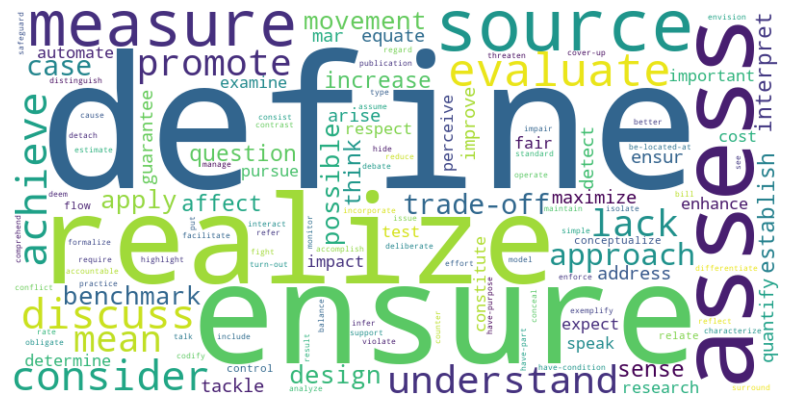

In [ ]:
countwordsarg1 = dict()
for index, list_parents in parents.items():
    for word_fair, list_parents in list_parents.items():
        for parent in list_parents:
            if parent[2] == ":ARG1":
                if parent[1] in countwordsarg1:
                    countwordsarg1[parent[1]] += 1
                else:
                    countwordsarg1[parent[1]] = 1

print("concept utilisé avec :ARG1 :")
top_10_arg1 = sorted(countwordsarg1.items(), key=lambda x: x[1], reverse=True)[:10]

# Afficher le Top 10
for key, value in top_10_arg1:
    print(f"{key}: {value}")

cleaned_countwordsarg1 = {}
for key, value in countwordsarg1.items():
    # Utiliser une regex pour enlever `-01`, `-02`, etc.
    base_key = re.sub(r"-\d+$", "", key)
    cleaned_countwordsarg1[base_key] = cleaned_countwordsarg1.get(
        base_key, 0) + value
    
# nuage de mots
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="viridis"
).generate_from_frequencies(cleaned_countwordsarg1)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Supprime les axes
plt.show()

**Analyses :**

Des mots ressortent forcement ; notamment : "define", "realize", "ensure".

Une traduction possible par nous serait :  
- "Définir l'équité" (ou "definition de l'équité" [trouver fair-01 et define-01])
- "garantir l'équité" (même remarque)
- etc.

